### Label curation 

- First Step to initialize

In [1]:
import torch 
from collections import Counter
import random
from datasets import load_dataset
import numpy as np
import math

seed =3
random.seed(seed)
np.random.seed(seed)

dataset_name='all_train'
# model_name="meta-llama/Meta-Llama-3.1-8B-Instruct"
model_name="gpt-4o-mini"
# model_name= "mistralai/Mistral-7B-Instruct-v0.3"

dataset_size = 10000
confidence_prob = 0.5


all_train_dataset = load_dataset('json', data_files =f"full_dataset.json")

#################################################################################################################################
# label curation reports
# report_path = f"/home/azureuser/cloudfiles/code/Users/jinlong.pang/LADR_LLM_alignment_data_refinement/labeling/results/{model_name}/{dataset_name}/{dataset_name}_report.pt"

report_path = f"results-embedding-model-bge/{model_name}/{dataset_name}/{dataset_name}_report.pt"



reports = torch.load(report_path)

# Part 1 (label-wise): label curation
corrupted_samples = [x[0] for x in reports.detection['label_error']]

cured_samples = []
cured_sample_labels = []
for sample in reports.curation['label_curation']:  # (idx, label, confidence)
    if sample[2] >= confidence_prob:  # confidence prob
        cured_samples.append(sample[0])
        cured_sample_labels.append((int(sample[0]), int(sample[1]), round(sample[2],2)))

print(f"Cured sample size: {len(cured_sample_labels)}")

# Filter out some cured samples from corrupted instances
cured_samples_set = set(cured_samples)
corrupted_samples_total = [x for x in corrupted_samples if x not in cured_samples_set]

print(f"Corrupted samples total: {len(corrupted_samples_total)}")

# Change the original labels to the suggested label
root_path = f"../open-instruct/new_train_data_labels/{model_name}/{dataset_name}/"


labels = torch.load(root_path + "output_labels_revised.pt")

print(f"Original Counter(labels): {Counter(labels)}")

count=0
#identify the transition labels
count_labels_5 = []
count_labels_4 = []
count_labels_3 = []
count_labels_2 = []

for sample_label in cured_sample_labels:
    if labels[sample_label[0]] == 5:
        count_labels_5.append(sample_label)
        # continue ## determine whether remain the 5-rated samples

    if labels[sample_label[0]] == 4:
        count_labels_4.append(sample_label)

    if labels[sample_label[0]] == 3:
        count_labels_3.append(sample_label)

    if labels[sample_label[0]] == 2:
        count_labels_2.append(sample_label)

    labels[sample_label[0]] = sample_label[1]
    count+=1

print(f"counting revised label size: {count}")

print(f"Label size: {len(labels)}")
label_counts = Counter(labels)

print(f"Revised Counter(labels): {label_counts}")

# Filter out the low-quality samples
label_wise_filter_out_samples = set(corrupted_samples_total)
print(f"Label-wise filter out samples: {len(label_wise_filter_out_samples)}")

### load the label noise 

# torch.save(labels, root_path + f"output_labels_revised_cured.pt")




#################################################################################################################################


/home/jlpang/Docta/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1538163/3981394206.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weig

==== Docta: Doctor for your data. Current version: 0.2 ====
Cured sample size: 10510
Corrupted samples total: 112457
Original Counter(labels): Counter({3: 87975, 2: 86132, 4: 59969, 1: 44401, 0: 18626, 5: 3829})
counting revised label size: 10510
Label size: 300932
Revised Counter(labels): Counter({3: 89665, 2: 86085, 4: 61057, 1: 43117, 0: 18503, 5: 2505})
Label-wise filter out samples: 112457


/tmp/ipykernel_1538163/3981394206.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(root_path + "output_labels_revised.pt")


In [2]:
len(reports.curation['label_curation']) 

122967

In [3]:
import numpy as np
from collections import Counter

selected_count_labels = count_labels_5

Counter(np.array([[int(a), int(b), float(c)] for a, b, c in selected_count_labels])[:,1])

Counter({np.float64(4.0): 1269,
         np.float64(3.0): 43,
         np.float64(2.0): 7,
         np.float64(1.0): 3,
         np.float64(0.0): 2})

In [4]:
target_low_label = 3
array_data = np.array([[int(a), int(b), float(c)] for a, b, c in selected_count_labels])
low_indices = np.where(array_data[:, 1]== target_low_label)


change_to_low_rated_samples = all_train_dataset['train'].select(low_indices[0])

In [5]:
change_to_low_rated_samples[2122]

IndexError: Invalid key: 2122 is out of bounds for size 43

In [ ]:
set(change_to_low_rated_samples['dataset'])

{'flan_v2'}

## Baseline: Label-filtered algorithm 

- tag: label-filtered

In [ ]:
import torch 
from collections import Counter
import random
from datasets import load_dataset
import numpy as np

seed = 3
random.seed(seed)
np.random.seed(seed)


label_filtered_indices = []
for target_label in [5, 4, 3, 2, 1]:
    if len(label_filtered_indices) == dataset_size:
        break   

    indices = [i for i, label in enumerate(labels) if label == target_label]

    if dataset_size - len(label_filtered_indices) > len(indices):
        label_filtered_indices.extend(indices)
    else:
        random_indices = np.random.permutation(len(indices))[:dataset_size-len(label_filtered_indices)]
        label_filtered_indices.extend(random_indices)

print(f"data size: {len(label_filtered_indices)}")

label_filtered_dataset = all_train_dataset['train'].select(label_filtered_indices)

label_filtered_labels = np.array(labels)[label_filtered_indices].tolist()

root_path = f"./model_finetune_cluster/new_train_data/{model_name}/{dataset_name}/"

label_filtered_dataset.to_json(root_path + f"label-filtered-cured-{confidence_prob}_dataset.json")


data size: 10000


Creating json from Arrow format: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.40ba/s]


16755007

## Baseline: diversity-filtered

- tag: diversity-filtered

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from datasets import load_dataset, Dataset
import random
import numpy as np
from tqdm import tqdm
import os

seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def cosDistance(sample_embedding, selected_embeddings, k_near=10):
    # 确保在GPU上执行
    sample_embedding = sample_embedding.to(device)
    selected_embeddings = selected_embeddings.to(device)

    similarity_vector = torch.matmul(selected_embeddings, sample_embedding)
    distance_vector = 1.0 - similarity_vector

    if selected_embeddings.size(0) > k_near:
        distance_vector, _ = torch.topk(distance_vector, k=k_near, dim=0)
    
    mean_distance = distance_vector.mean().item()  # .item()确保从张量转换为python标量
    return mean_distance

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def process_dialog(dialog):
    conversation = ""
    for message in dialog['messages']:
        conversation += f"### {message['role']}: {message['content']}\n"
    return {"features": conversation}

def embed_text(batch):
    encoded_inputs = tokenizer(batch['features'], padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        model_outputs = model(**encoded_inputs)
    sentence_embeddings = mean_pooling(model_outputs, encoded_inputs['attention_mask'])
    embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    
    batch['embeddings'] = embeddings.cpu().numpy().tolist()  # 确保从GPU传递回CPU进行保存
    return batch

##############################################################################################################################

threshold = 0.5
k_near = 10

if not os.path.exists(f"{dataset_name}_embeddings.parquet"):
    data = load_dataset('json', data_files=f"./data/train_data/{dataset_name}_data.jsonl")
    data['train'] = data['train'].map(process_dialog, batched=False)

    embedding_model_name = "BAAI/bge-large-en-v1.5"
    tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
    model = AutoModel.from_pretrained(embedding_model_name).to(device)
    model = torch.nn.DataParallel(model)

    data['train'] = data['train'].map(embed_text, batched=True, batch_size=2048)
    data['train'].to_parquet(f'{dataset_name}_embeddings.parquet')
    print(f"Embeddings saved to {dataset_name}_embeddings.parquet")

#########################################################################################################################

# 定义标签和优先级
label_priority = [5, 4, 3, 2, 1]
label_indices = {label: [idx for idx, lbl in enumerate(labels) if lbl == label] for label in label_priority}

embedding_dataset = load_dataset('parquet', data_files=f'{dataset_name}_embeddings.parquet')['train']

# 选择高质量样本
selected_embeddings = None
selected_samples = []

for label in label_priority:
    if len(selected_samples) >= dataset_size:
        break
    
    embedding_subset = embedding_dataset.select(label_indices[label])
    
    for sample in tqdm(embedding_subset, desc=f"Processing high-quality samples (label={label})"):
        sample_embedding = torch.tensor(sample['embeddings']).to(device)  # 确保 sample_embedding 在 GPU 上
        
        if selected_embeddings is None:
            selected_embeddings = sample_embedding.unsqueeze(0)
            selected_samples.append(sample)
            continue
        
        if cosDistance(sample_embedding, selected_embeddings, k_near=k_near) < threshold:
            selected_embeddings = torch.cat((selected_embeddings, sample_embedding.unsqueeze(0)), dim=0)
            selected_samples.append(sample)
        
        if len(selected_samples) >= dataset_size:
            break
    print(f"Selected data size from label {label}: {len(selected_samples)}")

selected_dataset = Dataset.from_dict({col: [s[col] for s in selected_samples] for col in selected_samples[0].keys()})
print(f"Selected data size: {len(selected_dataset)}")

selected_dataset.to_json(root_path + f'diversity-filtered-cured-{confidence_prob}_dataset.json', orient='records', lines=True)


Using device: cuda


Processing high-quality samples (label=5): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 487/487 [00:06<00:00, 73.24it/s]


Selected data size from label 5: 107


Processing high-quality samples (label=4): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66181/66181 [01:47<00:00, 617.09it/s]


Selected data size from label 4: 8085


Processing high-quality samples (label=3):   5%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 5460/118313 [00:04<01:40, 1125.26it/s]


Selected data size from label 3: 10000
Selected data size: 10000


Creating json from Arrow format: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.72ba/s]


177782124

## Filetered method: Our Data selection method

## Filtered 5: label-filtered based: all 5 samples  + 4-rated samples select using sorted long-tail score (reverse=True)

In [ ]:
import torch
import random
import numpy as np
from datasets import load_dataset
from collections import Counter

# 设置随机种子
seed = 3
random.seed(seed)
np.random.seed(seed)

# Part 2 (feature-wise): 处理稀有样本
rare_samples = reports.detection['rare_example'][:len(reports.detection['rare_example']) // 2]
rare_samples_filtered = np.array(rare_samples)[:, :2]  # 使用NumPy进行操作

print(f"Size of the remaining samples with high quality: {len(rare_samples_filtered)}")

# 假设 labels 是 Python 列表，将其转换为 NumPy 数组
labels = np.array(labels)

# 缓存标签索引
label_indices_cache = {label: np.where(labels == label)[0] for label in [5, 4, 3, 2, 1]}
print(f"Finished caching labels indices...")

filtered_indices = []

# 过滤样本并进行排序
for target_label in [5, 4, 3, 2, 1]:
    if len(filtered_indices) >= dataset_size:
        break

    label_indices = label_indices_cache[target_label]
    available_size = dataset_size - len(filtered_indices)

    if available_size > len(label_indices):
        filtered_indices.extend(label_indices.tolist())
    else:
        # 获取对应标签的样本并排序
        label_samples = rare_samples_filtered[np.isin(rare_samples_filtered[:, 0], label_indices)]
        if len(label_samples) > 0:  # 确保样本不为空
            sorted_samples = label_samples[label_samples[:, 1].argsort()[::-1]][:available_size]
            filtered_indices.extend(sorted_samples[:, 0].astype(int).tolist())

    print("Size of the filtered dataset:", len(filtered_indices))

# 加载数据集并过滤掉无效样本
data = load_dataset('json', data_files=root_path + 'full_dataset.json')

# 选择样本并保存
filtered_dialogs = data['train'].select(filtered_indices)
filtered_dialogs.to_json(root_path + f"filtered-cured-{confidence_prob}_dataset.json")


Size of the remaining samples with high quality: 300932
Finished caching labels indices...
Size of the filtered dataset: 2505
Size of the filtered dataset: 10000


FileNotFoundError: Unable to find '/home/jlpang/Docta/../open-instruct/new_train_data_labels/gpt-4o-mini/all_train/full_dataset.json'

## Selecting high-long-tail score v.s. low long-tail score

In [6]:
import torch
import random
import numpy as np
from datasets import load_dataset
from collections import Counter

# 设置随机种子
seed = 3
random.seed(seed)
np.random.seed(seed)

# Part 2 (feature-wise): 处理稀有样本
rare_samples = reports.detection['rare_example'][:len(reports.detection['rare_example']) // 2]
rare_samples_filtered = np.array(rare_samples)[:, :2]  # 使用NumPy进行操作

print(f"Size of the remaining samples with high quality: {len(rare_samples_filtered)}")

# 假设 labels 是 Python 列表，将其转换为 NumPy 数组
labels = np.array(labels)

# 缓存标签索引
label_indices_cache = {label: np.where(labels == label)[0] for label in [5, 4, 3, 2, 1]}
print(f"Finished caching labels indices...")

filtered_indices = {}

# 过滤样本并进行排序
for target_label in [5, 4, 3, 2, 1]:
    if len(filtered_indices) >= dataset_size:
        break

    label_indices = label_indices_cache[target_label]
    # available_size = dataset_size - len(filtered_indices)


    label_samples = rare_samples_filtered[np.isin(rare_samples_filtered[:, 0], label_indices)]
    if len(label_samples) > 0:  # 确保样本不为空
        sorted_samples = label_samples[label_samples[:, 1].argsort()[::-1]]
        filtered_indices[target_label] = sorted_samples[:, 0].astype(int).tolist()

    # print("Size of the filtered dataset:", len(filtered_indices))

# # 加载数据集并过滤掉无效样本
# data = load_dataset('json', data_files=root_path + 'full_dataset.json')

# # 选择样本并保存
# filtered_dialogs = data['train'].select(filtered_indices)
# # filtered_dialogs.to_json(root_path + f"filtered-cured-{confidence_prob}_dataset.json")


Size of the remaining samples with high quality: 300932
Finished caching labels indices...


In [73]:
filtered_indices

{5: [226703,
  233928,
  180009,
  99327,
  236102,
  460,
  165924,
  20397,
  248301,
  178,
  248836,
  216883,
  242914,
  204914,
  231773,
  75879,
  20744,
  208558,
  136707,
  76619,
  171016,
  10913,
  154469,
  191323,
  205411,
  213026,
  189628,
  152722,
  241821,
  175116,
  22162,
  191924,
  238459,
  155818,
  173670,
  32302,
  173016,
  205151,
  213333,
  174742,
  174476,
  225090,
  40040,
  231016,
  137334,
  160385,
  244415,
  238652,
  134729,
  30234,
  177746,
  220169,
  138454,
  55079,
  164253,
  189739,
  230831,
  200547,
  212511,
  238771,
  197565,
  176954,
  160657,
  154460,
  178073,
  232783,
  136100,
  151015,
  160173,
  156707,
  244237,
  181359,
  137629,
  192476,
  80271,
  169335,
  216405,
  233189,
  145397,
  164130,
  240265,
  216611,
  139950,
  214980,
  148058,
  245337,
  160961,
  210970,
  161063,
  170525,
  237393,
  193167,
  160471,
  220322,
  241874,
  189460,
  219718,
  202551,
  214309,
  202607,
  55083,
  1660

In [7]:
data = load_dataset('json', data_files='full_dataset.json')


high_long_tail_examples_indices = filtered_indices[5][:10]

low_long_tail_examples_indices = filtered_indices[5][-10:]

high_long_tail_examples = data['train'].select(filtered_indices[5][:5])


low_long_tail_examples =  data['train'].select(filtered_indices[5][-5:])

In [ ]:
high_long_tail_examples['messages'][1]

[{'role': 'user',
  'content': "Who was John Moses Browning?\n\nJohn Moses Browning (January 23, 1855 – November 26, 1926) was an American firearm designer who developed many varieties of military and civilian firearms, cartridges, and gun mechanisms – many of which are still in use around the world. He made his first firearm at age 13 in his father's gun shop and was awarded the first of his 128 firearm patents on October 7, 1879, at the age of 24. He is regarded as one of the most successful firearms designers of the 19th and 20th centuries and pioneered the development of modern repeating, semi-automatic, and automatic firearms.\n\nBrowning influenced nearly all categories of firearms design, especially the autoloading of ammunition. He invented, or made significant improvements to, single-shot, lever-action, and pump-action rifles and shotguns. He developed the first reliable and compact autoloading pistols by inventing the telescoping bolt, then integrating the bolt and barrel shr

In [ ]:
low_long_tail_examples['messages'][0]

[{'role': 'user',
  'content': "The invention of proximity fuse technology in anti-air artillery shells was one of America's best kept secrets during World War II, and arguably one of the most impactful advantages of the United States. Explain what a proximity fuse is, why it was so desirable compared to existing techniques, and why it was so challenging to achieve."},
 {'role': 'assistant',
  'content': "A proximity fuse is a type of fuse used in artillery shells, which detonates the shell at a pre-set distance from the target, rather than on impact. It was designed to increase the likelihood of hitting fast-moving airborne targets such as aircraft and drones, which were notoriously difficult to hit with traditional fuses that relied on timed detonation or contact with the target.\n\nPrior to the development of proximity fuses, anti-aircraft guns relied on visual tracking of the target and timed detonation to predict the target's location and intercept its flight path. This approach h

## plot the embedding vector in the embedding space.

In [23]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from datasets import load_dataset, Dataset
import random
import numpy as np
from tqdm import tqdm
import os

# 设置随机种子
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 计算余弦距离并返回 KNN 索引 (排除自身)
def cosDistance(sample_embedding, all_embeddings, k_near=10):
    # 确保在GPU上执行
    sample_embedding = sample_embedding.to(device)
    all_embeddings = all_embeddings.to(device)

    # 计算余弦相似度
    similarity_vector = torch.matmul(all_embeddings, sample_embedding)
    distance_vector = 1.0 - similarity_vector

    # 获取最近的 k + 1 个样本索引（包括自身）
    distance_vector, topk_indices = torch.topk(distance_vector, k=k_near+1, dim=0, largest=False)
    
    # 排除自身索引（假设自身是最接近的）
    if topk_indices[0] == torch.arange(all_embeddings.size(0))[0]:
        topk_indices = topk_indices[1:]
        distance_vector = distance_vector[1:]
        
    return distance_vector, topk_indices

# 平均池化函数
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # 获取 token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# 处理对话，将其转换为文本格式
def process_dialog(dialog):
    conversation = ""
    for message in dialog['messages']:
        conversation += f"### {message['role']}: {message['content']}\n"
    return {"features": conversation}

# 将文本嵌入生成
def embed_text(batch):
    encoded_inputs = tokenizer(batch['features'], padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        model_outputs = model(**encoded_inputs)
    sentence_embeddings = mean_pooling(model_outputs, encoded_inputs['attention_mask'])
    embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    
    batch['embeddings'] = embeddings.cpu().numpy().tolist()  # 将嵌入转移回 CPU
    return batch

##############################################################################################################################

# 设置数据集参数
k_near = 10
dataset_name = "all_train"  # 替换为你的数据集名称
dataset_size = 1000  # 设置要选择的数据集大小

# 加载或生成嵌入数据
if not os.path.exists(f"{dataset_name}_embeddings.parquet"):
    data = load_dataset('json', data_files=f"full_dataset.json")
    data['train'] = data['train'].map(process_dialog, batched=False)

    embedding_model_name = "BAAI/bge-large-en-v1.5"
    tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
    model = AutoModel.from_pretrained(embedding_model_name).to(device)
    model = torch.nn.DataParallel(model)

    data['train'] = data['train'].map(embed_text, batched=True, batch_size=2048)
    data['train'].to_parquet(f'{dataset_name}_embeddings.parquet')
    print(f"Embeddings saved to {dataset_name}_embeddings.parquet")

#########################################################################################################################

# 定义标签和优先级
label_priority = [5, 4, 3, 2, 1]

# 高质量样本索引
label_indices = high_long_tail_examples_indices  # 替换为你的标签索引

# 加载生成的嵌入数据集
embedding_dataset = load_dataset('parquet', data_files=f'{dataset_name}_embeddings.parquet')['train']

# 获取所有嵌入的数据
all_embeddings = torch.tensor(embedding_dataset['embeddings']).to(device)

# 选择高质量样本并记录 KNN 索引
high_low_knn_indices = {}

for label in ['high', 'low']:
    knn_indices = []
    # 使用特定标签的索引选择样本子集
    if label == 'high':
        embedding_subset = embedding_dataset.select(high_long_tail_examples_indices)
    else:
        embedding_subset = embedding_dataset.select(low_long_tail_examples_indices)

    for sample_idx, sample in enumerate(tqdm(embedding_subset, desc=f"Processing high-quality samples (label={label})")):
        sample_embedding = torch.tensor(sample['embeddings']).to(device)  # 确保 sample_embedding 在 GPU 上

        # 计算当前 sample 与所有嵌入的余弦距离，返回 KNN 索引，排除自身
        _, topk_indices = cosDistance(sample_embedding, all_embeddings, k_near=k_near)
        knn_indices.append(topk_indices.cpu().numpy().tolist())  # 记录当前样本的 KNN 索引

    high_low_knn_indices[label] = knn_indices

# 将选择的样本和 KNN 索引存储为新的 Dataset
# selected_dataset = Dataset.from_dict({
#     'samples': {col: [s[col] for s in selected_samples] for col in selected_samples[0].keys()},
#     'knn_indices': knn_indices  # 保存每个样本对应的 KNN 索引
# })

# print(f"Selected data size: {len(selected_dataset)}")

# 保存选出的数据到 JSON 文件（可选）
# selected_dataset.to_json(f'diversity-filtered-cured-dataset.json', orient='records', lines=True)


Using device: cuda


Processing high-quality samples (label=low): 100%|██████████| 10/10 [00:00<00:00, 406.74it/s]


In [24]:
high_long_tail_examples_indices

[226703, 233928, 180009, 99327, 236102, 460, 165924, 20397, 248301, 178]

In [25]:
low_long_tail_examples_indices

[244921, 113993, 86840, 30652, 116616, 109079, 123499, 109164, 85062, 117813]

In [26]:
high_low_knn_indices['low'][0]

[244921,
 242002,
 243080,
 239434,
 242706,
 246992,
 244567,
 244571,
 243293,
 242710,
 237570]

In [ ]:
high_low_knn_indices['high'][0]

[226703, 135851, 145134, 146425, 266068, 276007, 66115, 236803, 238672, 266189]

## PCA

In [53]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from datasets import load_dataset

# 加载生成的嵌入数据集
dataset_name = "all_train"  # 替换为你的数据集名称
embedding_dataset = load_dataset('parquet', data_files=f'{dataset_name}_embeddings.parquet')['train']

# 假设 labels 已经定义
rate_5_indices = [i for i, label in enumerate(labels) if label == 5]

# 获取所有嵌入的数据，并将它们从 GPU 转移到 CPU
pca_embeddings = embedding_dataset[rate_5_indices]['embeddings']

# 第一步：在所有数据上训练 PCA 模型

# 标准化嵌入数据
scaler = StandardScaler()
all_embeddings = np.array(embedding_dataset['embeddings'])  # 将整个嵌入数据集转换为 NumPy 数组
all_embeddings = scaler.fit_transform(all_embeddings)  # 进行归一化

# 在标准化后的数据上训练 PCA 模型
pca = PCA(n_components=2)
pca.fit(all_embeddings)  # 在整个数据集上拟合 PCA 模型




PCA(n_components=2)

Number of KNN indices for high: 11
Number of KNN indices for low: 11


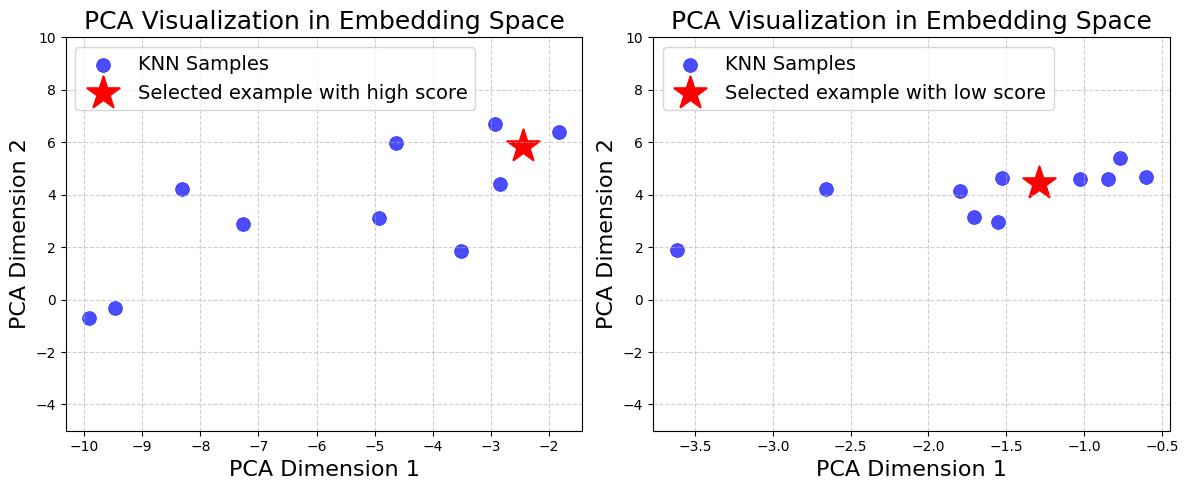

In [69]:
import matplotlib.pyplot as plt

# 创建 1x2 的子图布局
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # figsize 调整为适合两个子图的大小

for idx, label in enumerate(['high', 'low']):
    knn_indices = high_low_knn_indices[label]
    
    example_idx = 0  # 可替换为你要可视化的样本索引
    if label == 'high':
        example_org_idx = high_long_tail_examples_indices[example_idx] 
    else:
        example_org_idx = low_long_tail_examples_indices[example_idx] 

    knn_idxs = knn_indices[example_idx]  # 获取该样本的KNN索引
    print(f"Number of KNN indices for {label}: {len(knn_idxs)}")

    # 提取 example 和 KNN 样本的嵌入向量
    example_embedding = embedding_dataset[example_org_idx]['embeddings']
    knn_embeddings = [embedding_dataset[idx]['embeddings'] for idx in knn_idxs]

    # 将 example 和 knn embeddings 合并为一个矩阵，并转换为 NumPy 格式
    all_knn_embeddings = np.vstack([example_embedding] + knn_embeddings)
    all_knn_embeddings = torch.tensor(all_knn_embeddings).cpu().numpy()

    # 对 KNN 数据进行标准化处理
    all_knn_embeddings = scaler.transform(all_knn_embeddings)  # 使用之前的 scaler 进行标准化

    # 使用已训练的 PCA 模型来转换 KNN 数据
    embeddings_2d = pca.transform(all_knn_embeddings)

    # 绘制第 idx+1 个子图
    ax = axs[idx]
    
    # 绘制 KNN 样本的散点图，使用渐变颜色和透明度
    ax.scatter(embeddings_2d[1:, 0], embeddings_2d[1:, 1], color='blue', label='KNN Samples', 
               alpha=0.7, s=100, linewidth=0.5)

    # 绘制选中的样本，使用醒目的红色星号作为标记
    ax.scatter(embeddings_2d[0, 0], embeddings_2d[0, 1], color='red', label=f'Selected example with {label} score', 
               marker='*', s=600, linewidth=1.5)

    # 固定 y 轴的范围
    ax.set_ylim(-5, 10)

    # 添加网格线以帮助视觉对齐
    ax.grid(True, linestyle='--', alpha=0.6)

    # 设置标题和坐标轴标签的字体和大小
    ax.set_title(f"PCA Visualization in Embedding Space", fontsize=18)
    ax.set_xlabel("PCA Dimension 1", fontsize=16)
    ax.set_ylabel("PCA Dimension 2", fontsize=16)

    # 设置图例，调整字体大小
    ax.legend(loc='upper left', fontsize=14, frameon=True)

# 自动调整子图参数，避免图像重叠
plt.tight_layout()
plt.show()


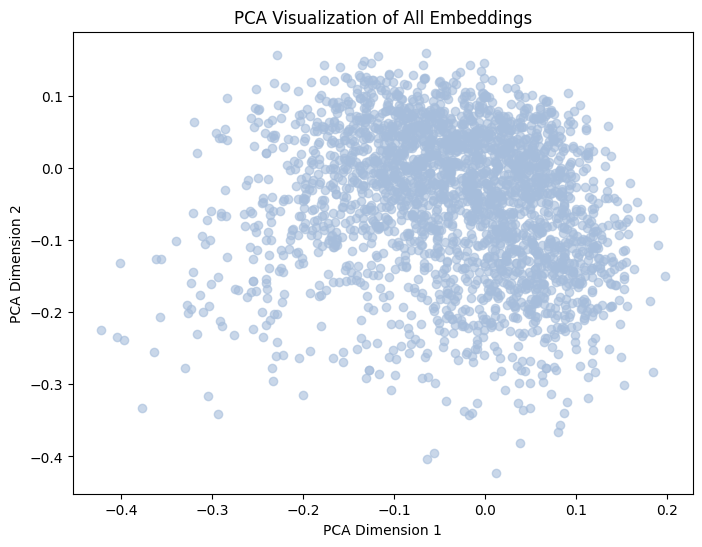

In [60]:

# 使用已经训练的 PCA 模型将嵌入数据降维到 2D 空间
scaler = StandardScaler()
all_embeddings = np.array(pca_embeddings)  # 将整个嵌入数据集转换为 NumPy 数组

embeddings_2d = pca.transform(all_embeddings)

# 绘制降维后的散点图
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6,color='#a6bddb')# color='#ADD8E6')

# 设置标题和标签
plt.title("PCA Visualization of All Embeddings")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")

# 显示图像
plt.show()


# Final figures

Number of KNN indices for high: 11
Number of KNN indices for low: 11


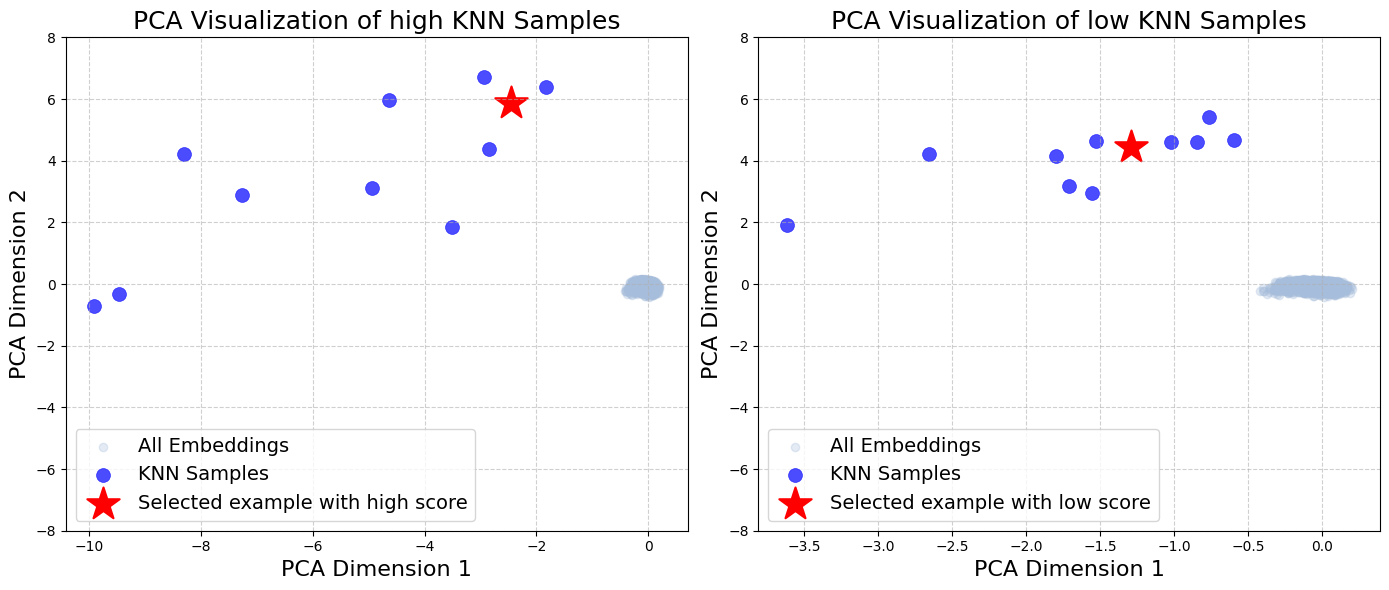

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 假设 pca_embeddings 和 high_low_knn_indices 已经定义好
scaler = StandardScaler()
scaler.fit(all_embeddings)  # 在所有数据上拟合 scaler

all_embeddings = np.array(pca_embeddings)  # 将整个嵌入数据集转换为 NumPy 数组

# 使用已经训练好的 PCA 模型降维到 2D 空间
embeddings_2d_all = pca.transform(all_embeddings)

# 创建 1x2 的子图布局
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # figsize 调整为适合两个子图的大小

for idx, label in enumerate(['high', 'low']):
    knn_indices = high_low_knn_indices[label]

    example_idx = 0  # 可替换为你要可视化的样本索引
    if label == 'high':
        example_org_idx = high_long_tail_examples_indices[example_idx] 
    else:
        example_org_idx = low_long_tail_examples_indices[example_idx] 

    knn_idxs = knn_indices[example_idx]  # 获取该样本的KNN索引
    print(f"Number of KNN indices for {label}: {len(knn_idxs)}")

    # 提取 example 和 KNN 样本的嵌入向量
    example_embedding = embedding_dataset[example_org_idx]['embeddings']
    knn_embeddings = [embedding_dataset[idx]['embeddings'] for idx in knn_idxs]

    # 将 example 和 knn embeddings 合并为一个矩阵，并转换为 NumPy 格式
    all_knn_embeddings = np.vstack([example_embedding] + knn_embeddings)
    all_knn_embeddings = torch.tensor(all_knn_embeddings).cpu().numpy()

    # 对 KNN 数据进行标准化处理
    all_knn_embeddings = scaler.transform(all_knn_embeddings)  # 使用之前的 scaler 进行标准化

    # 使用已训练的 PCA 模型来转换 KNN 数据
    embeddings_2d_knn = pca.transform(all_knn_embeddings)

    # 绘制每个子图
    ax = axs[idx]
    
    # 绘制整体嵌入空间的散点图作为背景，使用浅色
    ax.scatter(embeddings_2d_all[:, 0], embeddings_2d_all[:, 1], color='#a6bddb', alpha=0.3, label='All Embeddings')

    # 绘制 KNN 样本的散点图，使用蓝色
    ax.scatter(embeddings_2d_knn[1:, 0], embeddings_2d_knn[1:, 1], color='blue', label='KNN Samples', 
               alpha=0.7, s=100, linewidth=0.5)

    # 绘制选中的样本，使用醒目的红色星号作为标记
    ax.scatter(embeddings_2d_knn[0, 0], embeddings_2d_knn[0, 1], color='red', label=f'Selected example with {label} score', 
               marker='*', s=600, linewidth=1.5)

    # 固定 y 轴的范围
    ax.set_ylim(-8, 8)

    # 添加网格线以帮助视觉对齐
    ax.grid(True, linestyle='--', alpha=0.6)

    # 设置标题和坐标轴标签的字体和大小
    ax.set_title(f"PCA Visualization of {label} KNN Samples", fontsize=18)
    ax.set_xlabel("PCA Dimension 1", fontsize=16)
    ax.set_ylabel("PCA Dimension 2", fontsize=16)

    # 设置图例，调整字体大小
    ax.legend(loc='lower left', fontsize=14, frameon=True)

# 自动调整子图参数，避免图像重叠
plt.tight_layout()
plt.show()


Number of KNN indices for high: 11
Number of KNN indices for low: 11


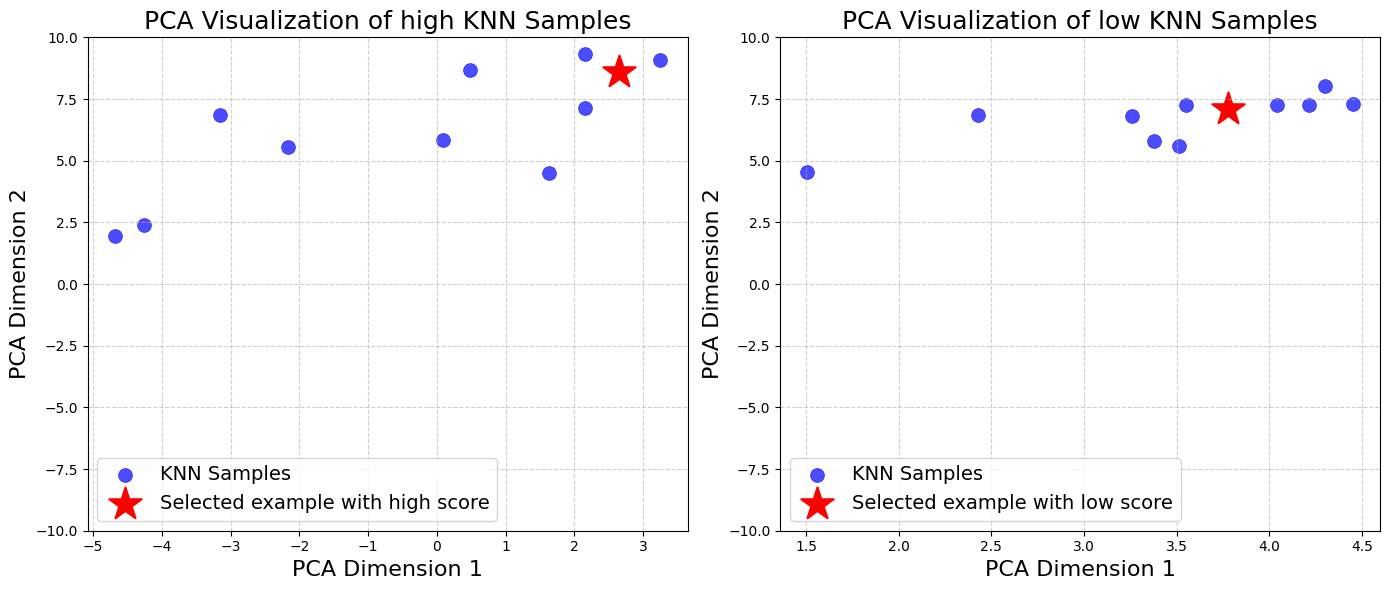

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datasets import load_dataset

# 加载生成的嵌入数据集
dataset_name = "all_train"  # 替换为你的数据集名称
embedding_dataset = load_dataset('parquet', data_files=f'{dataset_name}_embeddings.parquet')['train']

# 假设 labels 已经定义
# rate_5_indices = [i for i, label in enumerate(labels) if label == 5]

# 获取所有嵌入的数据，并将它们从 GPU 转移到 CPU
pca_embeddings = embedding_dataset[filtered_indices[5]]['embeddings']

# 标准化嵌入数据
scaler = StandardScaler()
all_embeddings = np.array(embedding_dataset['embeddings'])  # 将整个嵌入数据集转换为 NumPy 数组
all_embeddings = scaler.fit_transform(all_embeddings)  # 对所有数据进行标准化

# 在标准化后的数据上训练 PCA 模型
pca = PCA(n_components=2)
pca.fit(all_embeddings)  # 在整个数据集上拟合 PCA 模型

# 使用已经训练好的 PCA 模型降维到 2D 空间
embeddings_2d_all = pca.transform(all_embeddings)


Number of KNN indices for high: 11
Number of KNN indices for low: 11


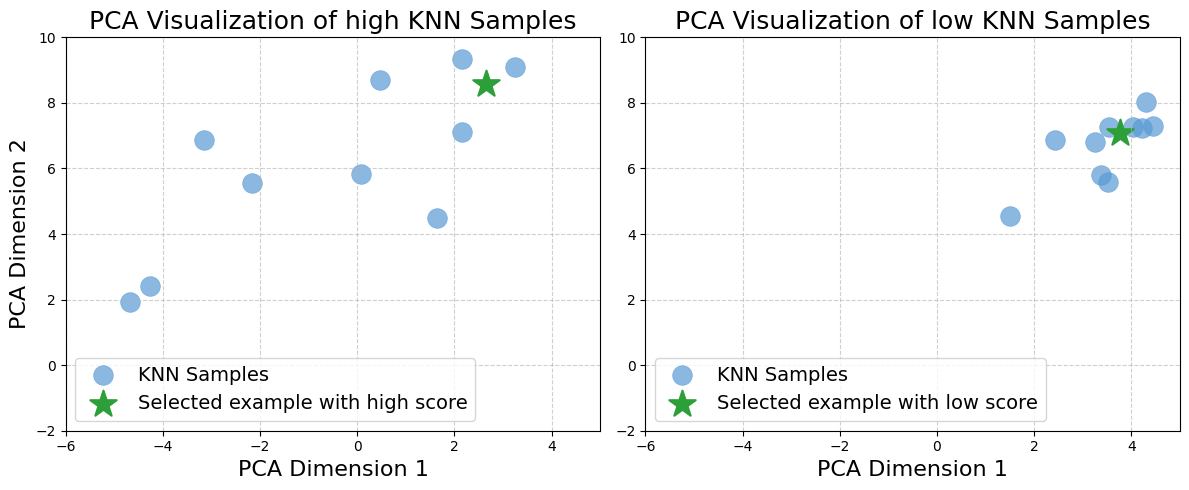

In [91]:

embeddings_2d_high_rated = pca.transform(pca_embeddings)

# 创建 1x2 的子图布局
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # figsize 调整为适合两个子图的大小

for idx, label in enumerate(['high', 'low']):
    knn_indices = high_low_knn_indices[label]

    example_idx = 0  # 可替换为你要可视化的样本索引
    if label == 'high':
        example_org_idx = high_long_tail_examples_indices[example_idx] 
    else:
        example_org_idx = low_long_tail_examples_indices[example_idx] 

    knn_idxs = knn_indices[example_idx]  # 获取该样本的KNN索引
    print(f"Number of KNN indices for {label}: {len(knn_idxs)}")

    # 提取 example 和 KNN 样本的嵌入向量
    example_embedding = embedding_dataset[example_org_idx]['embeddings']
    knn_embeddings = [embedding_dataset[idx]['embeddings'] for idx in knn_idxs]

    # 将 example 和 knn embeddings 合并为一个矩阵，并转换为 NumPy 格式
    all_knn_embeddings = np.vstack(knn_embeddings)
    all_knn_embeddings = scaler.transform(all_knn_embeddings)  # 使用之前的 scaler 进行标准化

    # 使用已训练的 PCA 模型来转换 KNN 数据
    embeddings_2d_knn = pca.transform(all_knn_embeddings)

    # 绘制每个子图
    ax = axs[idx]
    
    # 绘制整体嵌入空间的散点图作为背景，使用浅色
    # ax.scatter(embeddings_2d_high_rated[:, 0], embeddings_2d_high_rated[:, 1], color='#a6bddb', alpha=0.3, label='All Embeddings')

    # 绘制 KNN 样本的散点图，使用蓝色
    ax.scatter(embeddings_2d_knn[1:, 0], embeddings_2d_knn[1:, 1], color='#5A9BD5', label='KNN Samples', 
               alpha=0.7, s=200, linewidth=0.5)

    # 绘制选中的样本，使用醒目的红色星号作为标记
    ax.scatter(embeddings_2d_knn[0, 0], embeddings_2d_knn[0, 1], color='#2D9F39', label=f'Selected example with {label} score', 
               marker='*', s=400, linewidth=1.5)

    # 固定 y 轴的范围
    ax.set_ylim(-2, 10)
    ax.set_xlim(-6, 5)


    # 添加网格线以帮助视觉对齐
    ax.grid(True, linestyle='--', alpha=0.6)

    # 设置标题和坐标轴标签的字体和大小
    ax.set_title(f"PCA Visualization of Long", fontsize=18)
    ax.set_xlabel("PCA Dimension 1", fontsize=16)
    if idx == 0:
    
        ax.set_ylabel("PCA Dimension 2", fontsize=16) 
    
        
    # 设置图例，调整字体大小
    ax.legend(loc='lower left', fontsize=14, frameon=True)

# 自动调整子图参数，避免图像重叠
plt.tight_layout()
plt.show()


Number of KNN indices for high: 11
Number of KNN indices for low: 11


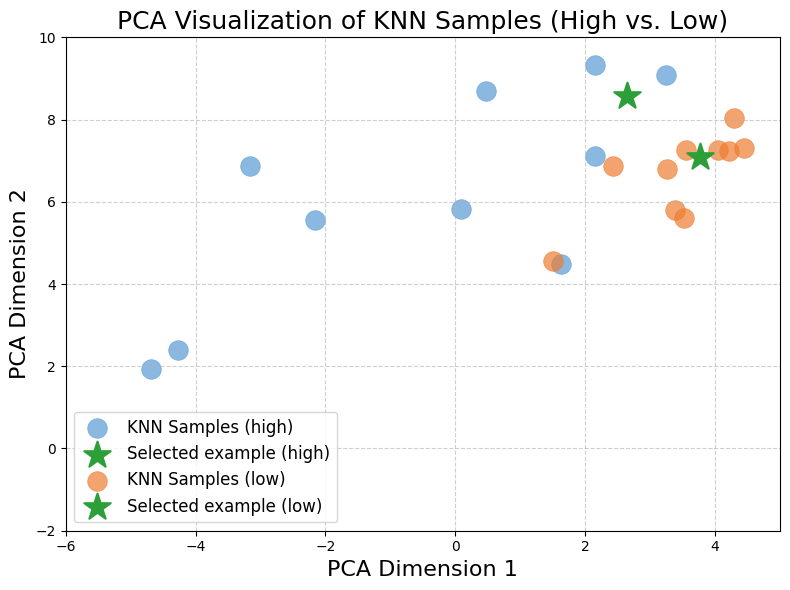

In [92]:
# 创建一个图，figsize 调整为合适的大小
fig, ax = plt.subplots(figsize=(8, 6)) 

# 固定坐标轴范围
x_lim = (-6, 5)  # 根据你的数据调整 x 轴范围
y_lim = (-2, 10)   # 根据你的数据调整 y 轴范围

colors = {'high': '#5A9BD5', 'low': '#ED7D31'}  # 定义颜色

for label in ['high', 'low']:
    knn_indices = high_low_knn_indices[label]

    example_idx = 0  # 可替换为你要可视化的样本索引
    if label == 'high':
        example_org_idx = high_long_tail_examples_indices[example_idx] 
    else:
        example_org_idx = low_long_tail_examples_indices[example_idx] 

    knn_idxs = knn_indices[example_idx]  # 获取该样本的KNN索引
    print(f"Number of KNN indices for {label}: {len(knn_idxs)}")

    # 提取 example 和 KNN 样本的嵌入向量
    example_embedding = embedding_dataset[example_org_idx]['embeddings']
    knn_embeddings = [embedding_dataset[idx]['embeddings'] for idx in knn_idxs]

    # 将 example 和 knn embeddings 合并为一个矩阵，并转换为 NumPy 格式
    all_knn_embeddings = np.vstack(knn_embeddings)
    all_knn_embeddings = scaler.transform(all_knn_embeddings)  # 使用之前的 scaler 进行标准化

    # 使用已训练的 PCA 模型来转换 KNN 数据
    embeddings_2d_knn = pca.transform(all_knn_embeddings)

    # 绘制 KNN 样本的散点图，使用不同颜色区分
    ax.scatter(embeddings_2d_knn[1:, 0], embeddings_2d_knn[1:, 1], color=colors[label], 
               label=f'KNN Samples ({label})', alpha=0.7, s=200, linewidth=0.5)

    # 绘制选中的样本，使用绿色星号作为标记
    ax.scatter(embeddings_2d_knn[0, 0], embeddings_2d_knn[0, 1], color='#2D9F39', 
               label=f'High ong-tail score target example', marker='*', s=400, linewidth=1.5)

# 固定 y 轴和 x 轴的范围
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

# 添加网格线以帮助视觉对齐
ax.grid(True, linestyle='--', alpha=0.6)

# 设置标题和坐标轴标签的字体和大小
ax.set_title("PCA Visualization of KNN Samples (High vs. Low)", fontsize=18)
ax.set_xlabel("PCA Dimension 1", fontsize=16)
ax.set_ylabel("PCA Dimension 2", fontsize=16)

# 设置图例，调整字体大小
ax.legend(loc='lower left', fontsize=12, frameon=True)

# 自动调整子图参数，避免图像重叠
plt.tight_layout()
plt.show()


Number of KNN indices for high: 11
Number of KNN indices for low: 11


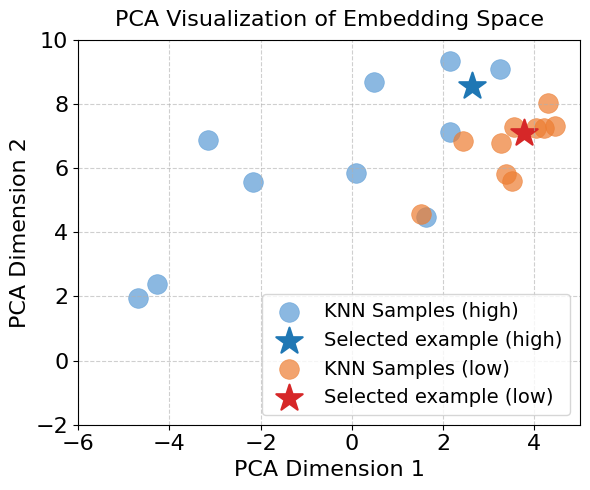

In [109]:
# 创建一个图，figsize 调整为合适的大小
fig, ax = plt.subplots(figsize=(6, 5)) 

# 固定坐标轴范围
x_lim = (-6, 5)  # 根据你的数据调整 x 轴范围
y_lim = (-2, 10)   # 根据你的数据调整 y 轴范围

# 定义颜色：高评级和低评级使用不同色系
colors = {
    'high_knn': '#5A9BD5',  # 浅蓝色用于 high 的 KNN 样本
    'high_selected': '#1F77B4',  # 深蓝色用于 high 的选定样本
    'low_knn': '#ED7D31',  # 浅橙色用于 low 的 KNN 样本
    'low_selected': '#D62728',  # 深橙色用于 low 的选定样本
}

for label in ['high', 'low']:
    knn_indices = high_low_knn_indices[label]

    if label == 'high':
        example_idx = 0  # 可替换为你要可视化的样本索引

        example_org_idx = high_long_tail_examples_indices[example_idx] 
        knn_color = colors['high_knn']
        selected_color = colors['high_selected']
    else:
        example_idx = 0  # 可替换为你要可视化的样本索引
        example_org_idx = low_long_tail_examples_indices[example_idx] 
        knn_color = colors['low_knn']
        selected_color = colors['low_selected']

    knn_idxs = knn_indices[example_idx]  # 获取该样本的KNN索引
    print(f"Number of KNN indices for {label}: {len(knn_idxs)}")

    # 提取 example 和 KNN 样本的嵌入向量
    example_embedding = embedding_dataset[example_org_idx]['embeddings']
    knn_embeddings = [embedding_dataset[idx]['embeddings'] for idx in knn_idxs]

    # 将 example 和 knn embeddings 合并为一个矩阵，并转换为 NumPy 格式
    all_knn_embeddings = np.vstack(knn_embeddings)
    all_knn_embeddings = scaler.transform(all_knn_embeddings)  # 使用之前的 scaler 进行标准化

    # 使用已训练的 PCA 模型来转换 KNN 数据
    embeddings_2d_knn = pca.transform(all_knn_embeddings)

    # 绘制 KNN 样本的散点图，使用不同颜色区分
    ax.scatter(embeddings_2d_knn[1:, 0], embeddings_2d_knn[1:, 1], color=knn_color, 
               label=f'KNN Samples ({label})', alpha=0.7, s=200, linewidth=0.5)

    # 绘制选中的样本，使用不同色调的星号标记
    ax.scatter(embeddings_2d_knn[0, 0], embeddings_2d_knn[0, 1], color=selected_color, 
               label=f'Selected example ({label})', marker='*', s=400, linewidth=1.5)

# 固定 y 轴和 x 轴的范围
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.tick_params(axis='both', which='major', labelsize=16)  # 设置主要刻度的字体大小
ax.tick_params(axis='both', which='minor', labelsize=16)  # 设置次要刻度的字体大小
# 添加网格线以帮助视觉对齐
ax.grid(True, linestyle='--', alpha=0.6)

# 设置标题和坐标轴标签的字体和大小
ax.set_title("PCA Visualization of Embedding Space", fontsize=16,pad=10)
ax.set_xlabel("PCA Dimension 1", fontsize=16)
ax.set_ylabel("PCA Dimension 2", fontsize=16)

# 设置图例，调整字体大小
ax.legend(loc='lower right', fontsize=14, frameon=True)

# 自动调整子图参数，避免图像重叠
plt.tight_layout()
plt.show()
